In [1]:
# %pip install ipympl

In [2]:
%matplotlib widget

import caiman as cm 
import matplotlib.pyplot as plt
import numpy as np
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.params import CNMFParams 
from caiman.source_extraction.cnmf import cnmf
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour, view_quilt, inspect_correlation_pnr, nb_inspect_correlation_pnr 
import sciebo

In [3]:
sciebo.download_file_from_sciebo('https://uni-bonn.sciebo.de/s/RR7qj7tklW1rX25', 'data', 'data_endoscope.tif')

## Preparing Data For Source Extraction

In [4]:
fname = "data/data_endoscope.tif"
movie_orig = cm.load(fname)

In [5]:
params = CNMFParams()

Change frame_rate to 10 and decay_time to 0.4 in the `data` part of params

In [6]:
params.data.update(
    {
        'fr': 10,
        'decay_time': 0.4
    }
)

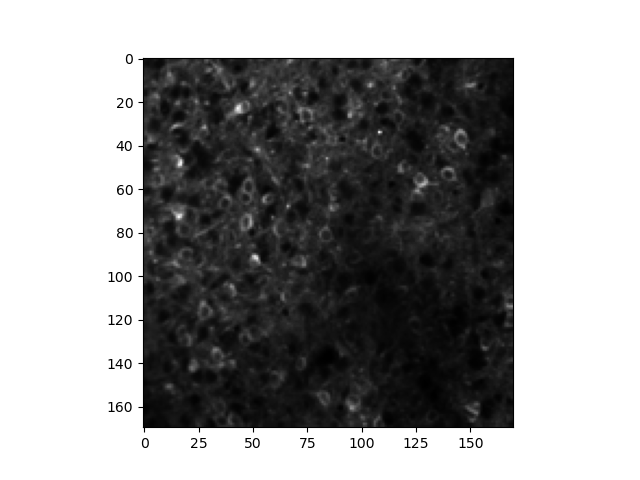

In [7]:
motion_params = {
    'pw_rigid': False,
    'max_shifts': (5, 5),
    'strides': (48, 48),
    'overlaps': (24, 24),
    'max_deviation_rigid': 3
}
params.motion.update(motion_params)

mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)

plt.imshow(mc.total_template_rig, cmap='gray')
plt.show();

For 1-photon imaging data, it is important to remove low-frequency background activity. Therefore, we apply a gaussian filter as pre-processing step

**Example** Redo the motion correction with the same params as above with a modification to 'gSig_filt' = (3, 3)

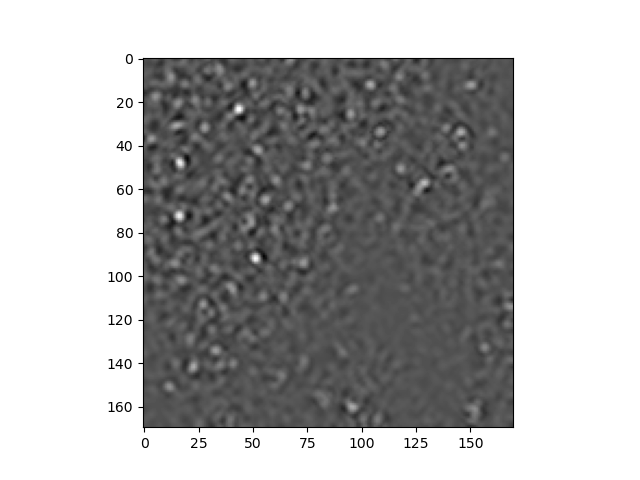

In [8]:
params.motion.update(
    {
        'gSig_filt': (3,3)
    }
)

mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)

plt.imshow(mc.total_template_rig, cmap='gray')
plt.show();

Redo the motion correction with 'gSig_filt' = (11, 11)

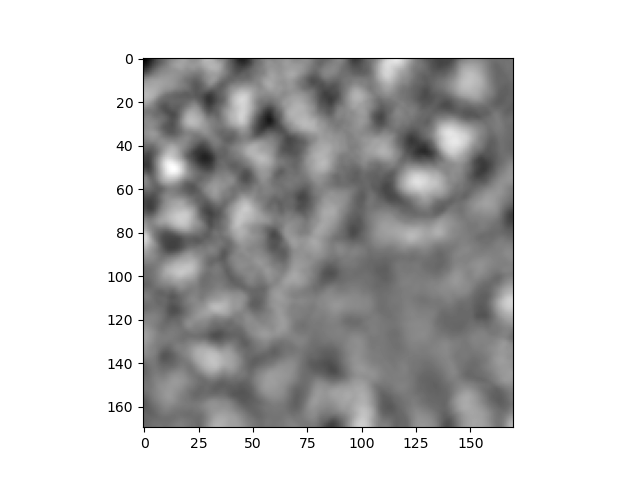

In [9]:
params.motion.update(
    {
        'gSig_filt': (11,11)
    }
)

mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)

plt.imshow(mc.total_template_rig, cmap='gray')
plt.show();

Let's exaggerate this even further! Redo the motion correction with 'gSig_filt' = (151, 151)

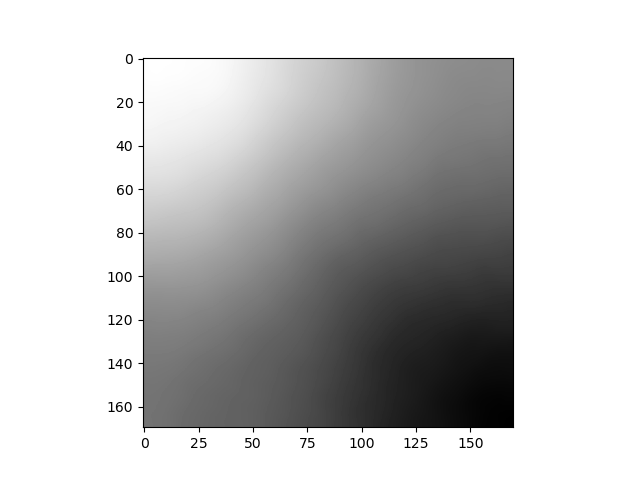

In [10]:
params.motion.update(
    {
        'gSig_filt': (151,151)
    }
)

mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)

plt.imshow(mc.total_template_rig, cmap='gray')
plt.show();

Great! Let's bring back the gaussian filter window to (3, 3) and finalize motion correction

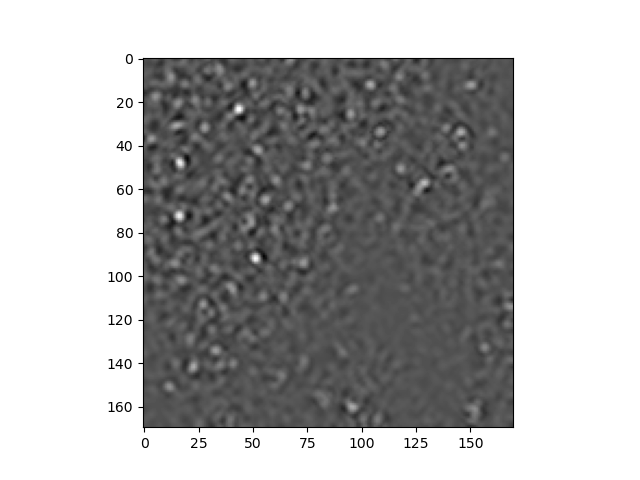

In [11]:
params.motion.update(
    {
        'gSig_filt': (3,3)
    }
)

mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)

plt.imshow(mc.total_template_rig, cmap='gray')
plt.show();

Now, let's transform the memory mapped file into a format that can be used by CaImAn for source extraction

In [12]:
mc_fname = mc.fname_tot_rig  
bord_px = 0  
fname_new = cm.save_memmap(mc_fname, base_name='memmap_', order='C', border_to_0=bord_px)

In [13]:
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

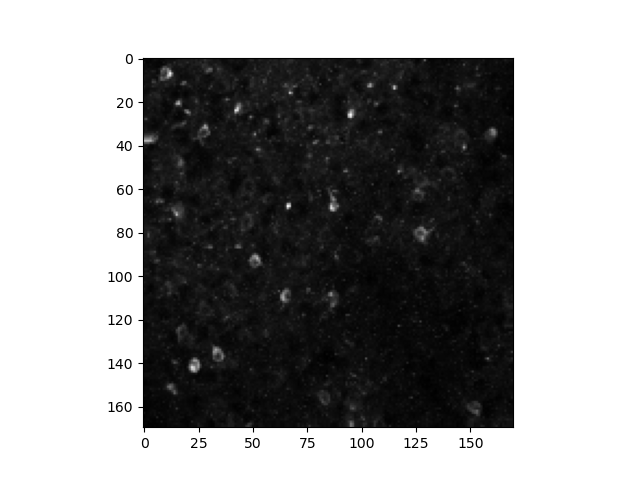

In [14]:
plt.imshow(np.max(images, axis=0), cmap='gray')
plt.show();

## CNMFE for 1-photon source extraction


There are two key parameters (along with a few more) that need to be set to trigger CNMFE algorithm instead of CNMF algorithm. 

They are:

1. nb = 0 (Number of background components. Setting this to 0 will make CaImAn use CNMFE algorithm)
2. method_init = 'corr_pnr' (Using correlation and Peak-to-Noise Ratio)

There are a few more that need to be set as well which we will try to do iteratively. At the end, we will consolidate these parameters

In [15]:
cnmfe_model = cnmf.CNMF(n_processes=1, params=params)

In [16]:
cnmfe_model.params

CNMFParams:

data:

{'caiman_version': '1.10.3',
 'decay_time': 0.4,
 'dims': None,
 'dxy': (1, 1),
 'fnames': None,
 'fr': 10,
 'last_commit': 'GITW-bd34b3097742ca8283e587f32e92e01e4889b79b',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': None,
 'nb': 1,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution': 'oasis',
 'nb': 1,
 'noise_method': 'mean',
 'noise_range': [0.25, 0.5],
 'n


**Example** Set 'method_init' to 'corr_pnr', 'nb' to 0, and 'center_psf' to True in params.

Inspect the image that opens in the browser. How many components did the model identify?

In [17]:
cnmfe_model.params.change_params(
    {
        'nb': 0,
        'method_init': 'corr_pnr',
        'center_psf': True
    }
)
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.
The number of pixels per process (n_pixels_per_process) is larger than the total number of pixels!! Decreasing suitably.


/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Let's try to set other parameters to identify more components. It's better to have false positives than false negatives as we can remove the bad components using quality metrics (another notebook)

Set 'gSig' to np.array([3, 3]) and 'gSiz' to np.array([7, 7]). 'gSiz' is usually twice the value of 'gSig'

In [18]:
cnmfe_model.params.change_params(
    {
        'gSig': np.array([3, 3]),
        'gSiz': np.array([7, 7])
    }
)
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Let's remove the upper bound in K (number of components per patch) by making it `None` and set order of autoregressive (p) to 1. 

Optional: Downsample in time (`tsub`) by a factor of more than 2 and/or space (`ssub`) by a factor of more than 1 if memory issues come up

In [19]:
cnmfe_model.params.change_params(
    {
        'K': None,
        'p': 1,
        'tsub': 2,
        'ssub': 1
    }
)
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Let's consolidate the important parameters that you can set or modify for 1-photon data 

In [20]:
cnmfe_model.params.change_params({
                                'method_init': 'corr_pnr',
                                'K': None,
                                'gSig': np.array([3,3]),
                                'gSiz': np.array([7,7]),
                                'p': 1,
                                'tsub': 2,
                                'ssub': 1,
                                'ssub_B': 2,
                                'nb': 0,
                                'nb_patch': 0,
                                'min_corr': 0.8,
                                'min_pnr': 10,
                                'center_psf': True,
                                'merge_thr': 0.7,
                                'low_rank_background': None,
                                'update_background_components': True,
                                'del_duplicates': True,
                                'rf': 40,
                                'stride': 20
})
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encount

There are still two parameters that may need modification. 

`min_corr` and `min_pnr` are **really** important parameters that control how many components are identified. 

Any pixel below `min_corr` value in the correlation image will be filtered out. Similarly, any pixels below `min_pnr` will also be filtered out. Therefore, setting these values as low as possible to retain most of the components is important

Set `min_corr` to 1.0 and `min_pnr` to 30. How many components are identified? 

In [21]:
cnmfe_model.params.change_params(
    {
        'min_corr': 1.0,
        'min_pnr': 30,
    }
)
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Set `min_corr` to 0.5 and `min_pnr` to 15. How many components are identified? 

In [22]:
cnmfe_model.params.change_params(
    {
        'min_corr': 0.5,
        'min_pnr': 15,
    }
)
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encount

Let's use a vizualization that will help us set min_corr and min_pnr

In the resulting plot, adjust vmin of correlation image and PNR such that the images are mostly neurons and less of noise. The vmin values can be used as min_corr and min_pnr 

Remember that we need a lower bound and not the upper bound. Higher values will result in more false negatives

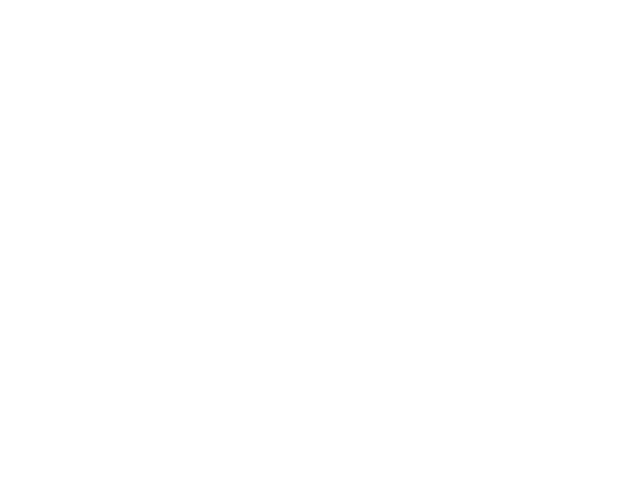

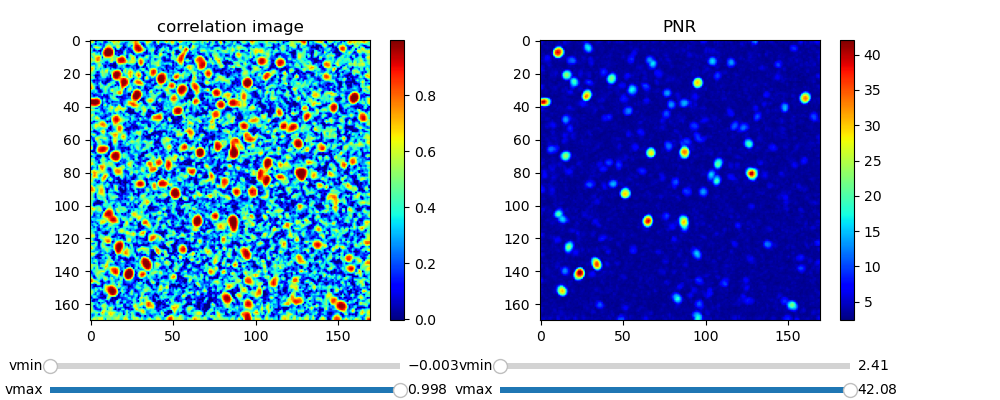

In [23]:
gsig = (3, 3)
plt.figure()
correlation_image, peak_to_noise_ratio = cm.summary_images.correlation_pnr(images[::max(T//1000, 1)], 
                                                                           gSig=gsig[0], 
                                                                           swap_dim=False)

inspect_correlation_pnr(correlation_image, peak_to_noise_ratio)

In the below cell, change min_corr and min_pnr

In [24]:
min_corr = 0.8
min_pnr = 12

cnmfe_model.params.change_params({
                                'method_init': 'corr_pnr',
                                'K': None,
                                'gSig': np.array([3,3]),
                                'gSiz': np.array([7,7]),
                                'p': 1,
                                'tsub': 2,
                                'ssub': 1,
                                'ssub_B': 2,
                                'nb': 0,
                                'nb_patch': 0,
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'center_psf': True,
                                'merge_thr': 0.7,
                                'low_rank_background': None,
                                'update_background_components': True,
                                'del_duplicates': True,
                                'rf': 40,
                                'stride': 20
})
cnmfe_fit = cnmfe_model.fit(images)
corr_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=corr_image);

/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/home/gitpod/miniconda/envs/caiman/lib/python3.10/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encount

## Exploring the Estimates Class


**Example** How many components were identified here?

In [25]:
cnmfe_fit.estimates.C.shape

(58, 3000)

**Example** Converting to pandas dataframe

In [26]:
import pandas as pd

frame_rate = cnmfe_fit.params.data['fr']
frame_pd = 1/frame_rate
frame_times = np.linspace(0, T*frame_pd, T);

data_to_save = np.vstack((frame_times, cnmfe_fit.estimates.S)).T  # Transpose so time series are in columns
save_df = pd.DataFrame(data_to_save)
save_df.rename(columns={0:'time'}, inplace=True)
# save_df.to_csv('1p_spike_counts.csv')

**Example** Plot denoised calcium traces of the first component

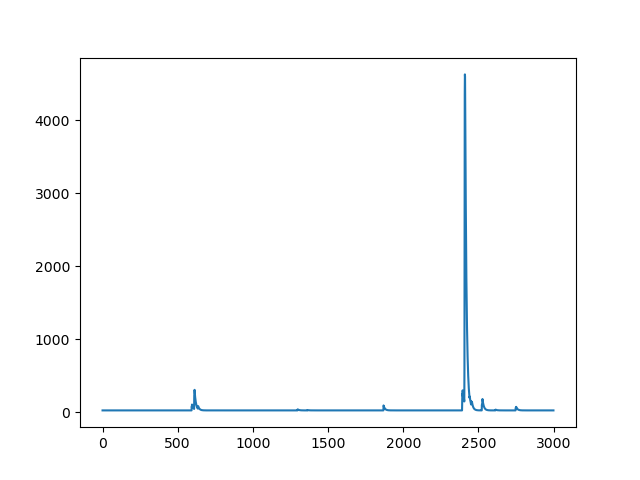

In [27]:
plt.figure()
plt.plot(cnmfe_fit.estimates.C[0])
plt.show();

**Example** Plot spike counts of first component

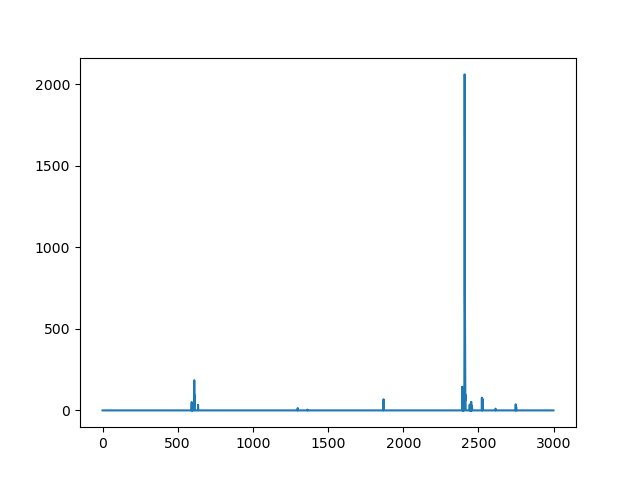

In [28]:
plt.figure()
plt.plot(cnmfe_fit.estimates.S[0])
plt.show();

**Example** Plot spike counts with spike times of first component

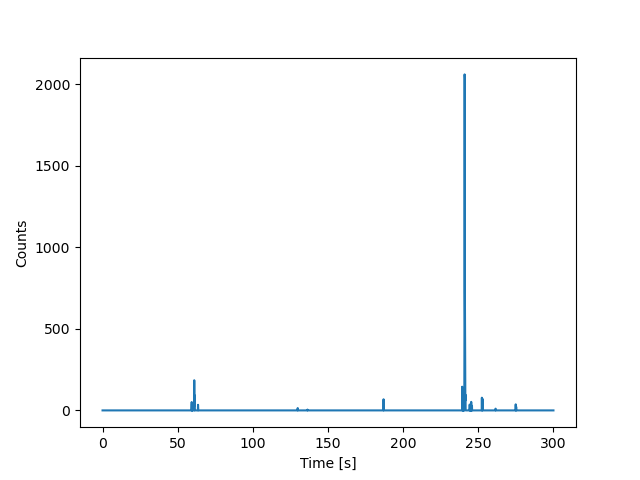

In [29]:
plt.clf()
plt.plot(save_df['time'], save_df[1])
plt.xlabel('Time [s]')
plt.ylabel('Counts')
plt.show();

## Extra exercises

1. Set min_corr, min_pnr to very low and very high values. How does this affect the results?
2. Try changing other parameters to different values and see how it affects the results